In [56]:
# IMPORTS
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
colors = sns.color_palette('colorblind')

/Users/a.cablant/Documents/GitHub/CRITEO-INTERNSHIP/Stochastic/src/environment/tree.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


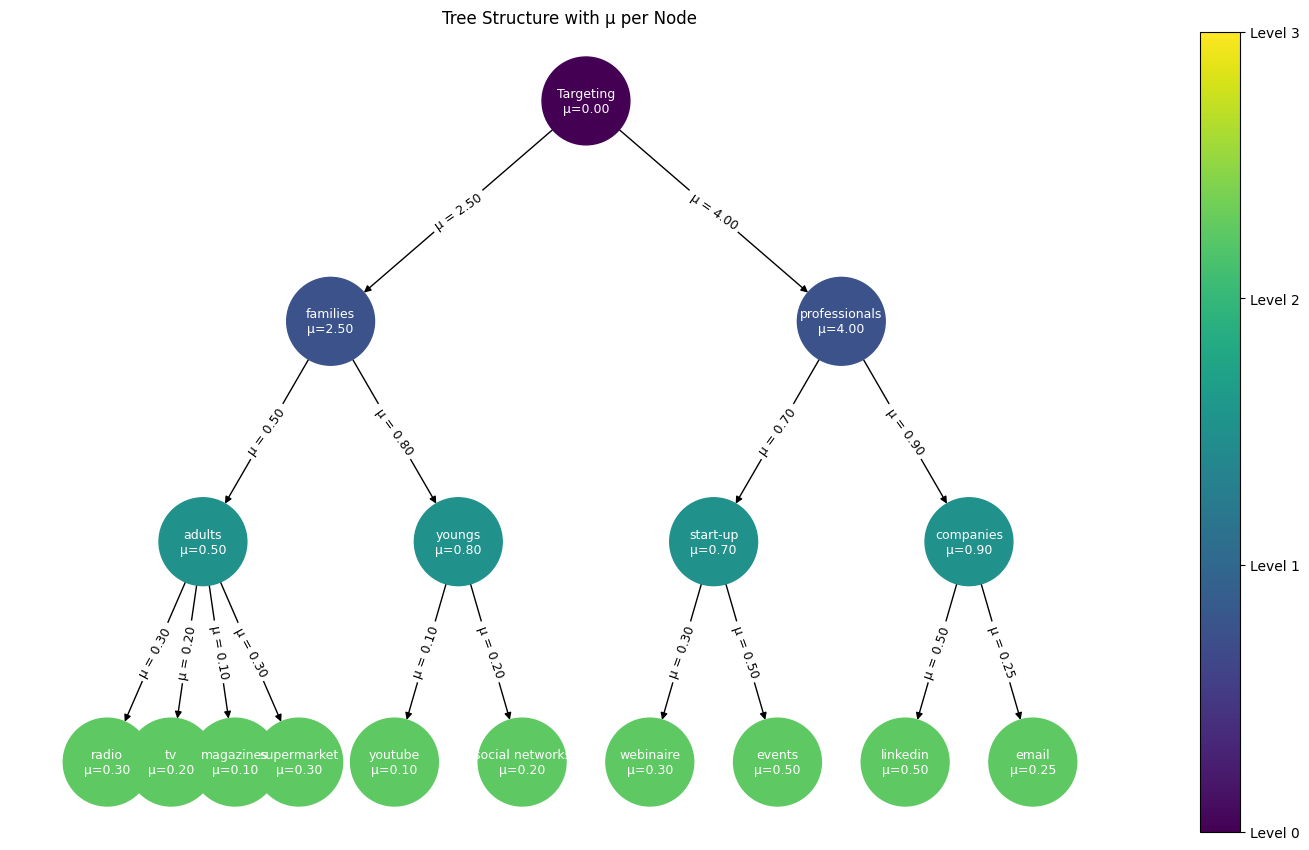

In [84]:
import gym
from gym import spaces
import numpy as np
from Stochastic.src.environment.tree import Tree

tree = Tree() 
root = tree.insert(parent_node=None, name="Targeting", mean=0, var=0)

# First Layer
families, _ = tree.insert(parent_node=root, name="families", mean=2.5, var=0.1)
professionals, _ = tree.insert(parent_node=root, name="professionals", mean=4.0, var=0.1)

# Second Layer
adults, _ = tree.insert(parent_node=families, name="adults", mean=0.5, var=0.1)
youngs, _ = tree.insert(parent_node=families, name="youngs", mean=0.8, var=0.1)

start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=0.7, var=0.1)
companies, _ = tree.insert(parent_node=professionals, name="companies", mean=0.9, var=0.1)

# Third Layer
radio, _ = tree.insert(parent_node=adults, name="radio", mean=0.3, var=0.1)
tv, _ = tree.insert(parent_node=adults, name="tv", mean=0.2, var=0.1)
magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=0.1, var=0.1)
tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=0.3, var=0.1)

youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=0.1, var=0.1)
social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=0.2, var=0.1)

webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=0.3, var=0.1)
events, _ = tree.insert(parent_node=start_up, name="events", mean=0.5, var=0.1)

linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=0.5, var=0.1)
email, _ = tree.insert(parent_node=companies, name="email", mean=0.25, var=0.1)

tree.step()
tree.visualize_tree_mu()

class NestedBanditEnv(gym.Env):
    """
    Nested Bandit environment where each arm is a full path from root to leaf in a tree.
    The reward is the sum of sampled node values along the path.
    """

    def __init__(self, tree=tree, seed=None):
        super(NestedBanditEnv, self).__init__()
        self.tree = tree
        self.rng = np.random.default_rng(seed)

        self.tree.step()  # initial sampling
        self.leaves = self.tree.get_all_leaves()
        self.K = len(self.leaves)
        self.best_arm = np.argmax([value[2] for value in self.tree.get_mu_leaves()])

        self.action_space = spaces.Discrete(self.K)
        self.observation_space = spaces.Discrete(1)  # stateless

        self.reset()

    def reset(self):
        self.t = 0
        self.tree.step()  

    def step(self, action):
        assert self.action_space.contains(action), "Invalid action index"
        self.t += 1

        selected_leaf = self.leaves[action]
        reward = self.tree.get_reward_leaf(selected_leaf)
        expected_reward = self.tree.get_mu_leaf(selected_leaf)

        best_arm_path = self.tree.find_best_arm_path()
        best_expected_reward = np.sum([node.mean for node in best_arm_path])
        best_leaf = best_arm_path[-1].name

        done = False
        info = {
            "step": self.t,
            "selected_leaf": selected_leaf.name,
            "expected_reward": expected_reward,
            "optimal": best_leaf,
            "path": best_arm_path,
            "best_expected_reward": best_expected_reward
        }
        self.tree.step()
        return 0, reward, done, info

    def render(self, mode="human"):
        self.tree.visualize_tree_mu()


In [58]:
import seaborn as sns 
from tqdm import tqdm
colors = sns.color_palette('colorblind')
import matplotlib.pyplot as plt

def experiment(environment, agents, Nmc, T):
    all_data = {}
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)
        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))

    for episode in tqdm(range(Nmc)):
        environment.reset()
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                index_action = agent.draw_action(environment.tree)
            else:
                index_action = agent.draw_action()
            _, r, _, info = environment.step(index_action)
            agent.observe_reward(r)

            # Compute pseudo-regret: 
            data[episode, t] = info["best_expected_reward"] - info["expected_reward"] 
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None, UCB_regret=False):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()


import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Palette de couleurs (modifiable selon le nombre d'agents)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

def plot_regret_and_histogram(regrets, agents, env, logscale=False, lb=None, q=10, save_pdf=None):
    """
    Plot cumulative regret and histogram of actions played by each agent.
    
    regrets : dict {'agent_name': np.array of regret}
    agents  : list of agent instances, each must have .action_history (flat list of actions played)
    """

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
    ax_regret, ax_hist = axes

    # --- Regret plot ---
    for i, (agent_id, data) in enumerate(regrets.items()):
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1)
        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

        ax_regret.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        ax_regret.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        ax_regret.set_xscale('log')
        ax_regret.set_xlim(left=100)

    if lb is not None:
        ax_regret.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10), label="bound")

    ax_regret.set_ylabel("Cumulative Regret")
    ax_regret.set_xlabel("Time steps")
    ax_regret.legend()
    ax_regret.set_title("Cumulative Regret per Agent")

    # --- Histogram plot ---
    width = 0.8 / len(agents)  # Adjust width for overlap

    for i, agent in enumerate(agents):
        if not hasattr(agent, "action_history"):
            continue  # Skip if no action data

        action_counts = Counter(agent.action_history)
        actions = sorted(action_counts.keys())
        freqs = [action_counts[a] for a in actions]

        x = np.array(actions) + i * width - (len(agents)/2) * width + width/2
        ax_hist.bar(x, freqs, width=width, color=colors[i], alpha=0.8, label=agent.name())

    ax_hist.set_xlabel("Arm")
    ax_hist.set_ylabel("Frequency")
    ax_hist.set_title(f"Actions Played by Each Agent (Best arm = {env.best_arm})")
    ax_hist.legend()

    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf)
    plt.show()

In [59]:
class Exp3:
    def __init__(self, tree):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)              
        self.EPS = 1e-8   
        self.T = 1_000      
        self.reset()     

    def reset(self):
        self.total_reward = 0
        self.p = np.full(self.K, 1.0 / self.K)   #UNIFORM DISTRIUBUTION
        self.R = np.zeros(self.K)
        self.environment_observe_losses = np.zeros(self.K)  #TO COMPUTE PSEUDO-REGRET
        self.incurred_loss = 0
        self.t = 0
        #self.eta = np.sqrt(2*np.log(self.K)/self.T*self.K)
        self.eta = 1 / self.K
        self.action_history = []

    def draw_action(self):
        self.t += 1
        self.eta = min(1//self.K, np.sqrt(np.log(self.K)/self.K*self.t))
        I_t = np.random.choice(range(self.K), p=self.p)
        self.index_action_chosen = I_t
        self.action_history.append(I_t)
        return I_t

    def observe_reward(self, r):
        self.R[self.index_action_chosen] += r / self.p[self.index_action_chosen]
        num = np.exp(-self.eta*self.R)
        self.p = num / np.sum(num)


    def name(self):
        return 'Exp3'
    
    def nested(self):
        return False


In [60]:
class UCB:
  def __init__(self, tree):
        self.tree = tree
        self.action_set = self.tree.get_all_leaves()
        self.K = len(self.action_set)       
        self.action_set = np.arange(self.K)
        self.reset()     

  def reset(self, seed=None):
      self.rng = np.random.default_rng(seed)
      self.total_reward = 0
      self.t = 0  
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.action_history = []
  
  def draw_action(self):
    if self.t < self.K:
        action = self.t % self.K
    else:
        with np.errstate(divide='ignore', invalid='ignore'):
                empirical_means = np.divide(self.count_rewards, self.count_actions, out=np.zeros_like(self.count_rewards), where=self.count_actions != 0)
                ucbs = np.sqrt(2 * np.log(self.t) / self.count_actions)
                scores = empirical_means + ucbs
                action = np.argmax(scores)

    self.t += 1
    self.count_actions[action] += 1
    self.chosen_action = action
    self.action_history.append(action)
    return action

  def observe_reward(self, reward):
    self.total_reward += reward
    self.count_rewards[self.chosen_action] += reward

  def name(self):
    return 'UCB' 
  
  def nested(self):
      return False

In [119]:
dico_leaf_i = {n.name:i for i,n in enumerate(tree.get_all_leaves())}
dico_leaf_i

{'radio': 0,
 'tv': 1,
 'magazines': 2,
 'supermarket': 3,
 'youtube': 4,
 'social networks': 5,
 'webinaire': 6,
 'events': 7,
 'linkedin': 8,
 'email': 9}

In [ ]:
import numpy as np

class NestedExponentialWeights:
    def __init__(self, tree, rng_seed=None):
        self.tree = tree
        self.leaves_set = self.tree.get_all_leaves()
        self.dico_leaf_i = {n.name:i for i,n in enumerate(self.leaves_set)}
        self.leaves_name = [n.name for n in self.leaves_set]
        self.K = len(self.leaves_set)
        self.rng = np.random.default_rng(rng_seed)
        self.EPS = 1e-8
        self.all_nodes = self.tree.get_all_nodes()
        self.nb_nodes = len(self.all_nodes)
        self.dic_name_i = {node.name:i for i,node in enumerate(self.all_nodes)}
        self.dic_i_name = {i:node.name for i,node in enumerate(self.all_nodes)}
        self.reset()

    def reset(self):
        self.t = 0
        self.action_history = []
        self.rewards = []
        self.Y = np.zeros(self.nb_nodes)

    def vector_proba(self, y):
        stable_exp_y = np.exp(y - np.max(y))
        sum_exp = np.sum(stable_exp_y)
        if not np.isfinite(sum_exp) or sum_exp == 0:
            # Sécurité : retourne une distribution uniforme
            return np.ones_like(stable_exp_y) / len(stable_exp_y)
        return stable_exp_y / sum_exp

    def draw_action(self, tree_step):
        self.t += 1
        tree = tree_step 
        self.backward()
        self.r = np.zeros(self.nb_nodes)

        node = tree.root 
        index = []
        node_path = []
        proba_path = []
        reward_path = []
        while bool(node.children):
            lr = 1 / np.sqrt(self.t + 1)
            childrens = node.children
            idxs = [self.dic_name_i[n.name] for n in childrens]
            Y = self.Y[idxs]
            proba = self.vector_proba(Y * lr)
            idx_node = self.rng.choice(range(len(childrens)), p=proba)
            chosen_children = childrens[idx_node]
            index.append(self.dic_name_i[chosen_children.name])
            node_path.append(idx_node)
            proba_path.append(Y[idx_node])
            intermediate_reward = chosen_children.value
            reward_path.append(intermediate_reward)
            node = chosen_children
        self.update(tree_step, index, node_path, proba_path, reward_path)
        idx_leaf = self.dico_leaf_i[node.name]
        self.action_history.append(idx_leaf)
        return idx_leaf
    
    def update(self, tree_step, index, node_path, proba_path, reward_path):
        node = tree_step.root  
        proba = 1 
        for i, j, p, r in zip(index, node_path, proba_path, reward_path):
            proba *= p
            self.Y[i] += r / (proba + self.EPS)
            node = node.children[j]

    def backward(self):
        visited = set()
        def _recursive_update(node):
            if node in visited:
                return
            visited.add(node)
            children = node.children
            if not children:
                return 
            children_indices = [self.dic_name_i[child.name] for child in children]
            sum_children = np.log(np.sum(np.exp([self.Y[idx] for idx in children_indices])))
            self.Y[self.dic_name_i[node.name]] = sum_children
            if node.parent:
                _recursive_update(node.parent)
        for leaf in self.leaves_set:
            if leaf.parent:
                _recursive_update(leaf.parent)

    def observe_reward(self, r):
        self.rewards.append(r)

    def name(self):
        return "NEW"
    
    def nested(self):
        return True

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_54991/539083657.py:79: RuntimeWarning: overflow encountered in exp
  sum_children = np.log(np.sum(np.exp([self.Y[idx] for idx in children_indices])))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_54991/539083657.py:25: RuntimeWarning: invalid value encountered in subtract
  stable_exp_y = np.exp(y - np.max(y))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_54991/539083657.py:65: RuntimeWarning: invalid value encountered in scalar multiply
  proba *= p
100%|██████████| 10/10 [00:01<00:00,  7.98it/s]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_54991/166761572.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


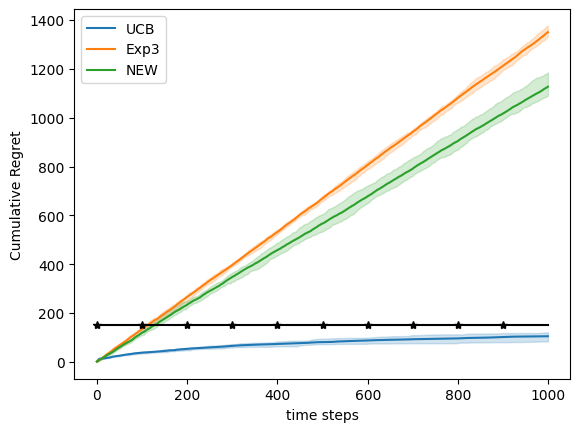

In [131]:
env = NestedBanditEnv()
tree = env.tree
exp3 = Exp3(tree)
ucb = UCB(tree)
new = NestedExponentialWeights(tree)

T = 1_000
K = 10

regrets = experiment(environment=env, agents=[ucb, exp3, new], Nmc=10, T=T)
plot_regret(regrets, logscale=False, lb=[np.sqrt(K*T*np.log(K))]*T, q=10, save_pdf=None)

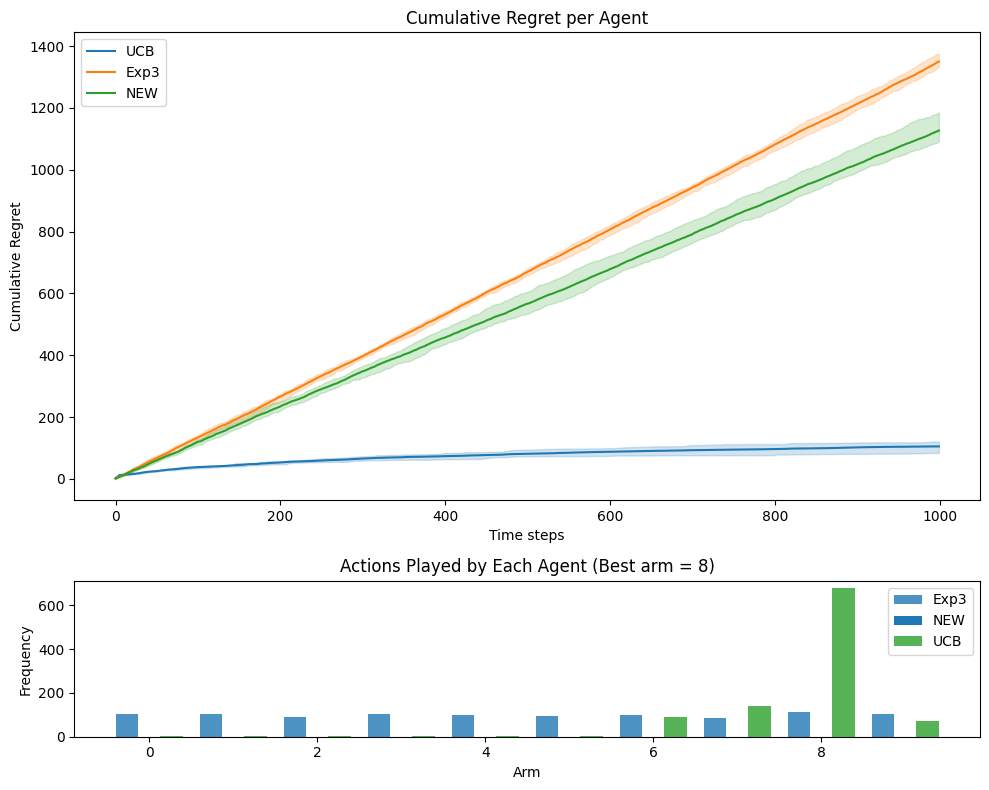

In [132]:
plot_regret_and_histogram(regrets, agents=[exp3, new, ucb], env=env, logscale=False, lb=None, q=10, save_pdf=None)